<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/01_mlp_optimizer_dropout_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizer 비교 (SGD vs Adam), Dropout 유무 비교

##✅ 실험 설계
우리는 동일한 MLP 모델, 동일한 데이터셋(MNIST)을 사용해서
학습 조건만 바꿔가며 비교 실험을 진행.

### 1. 공통 조건

모델 구조: MLP (28×28 → 128 → 64 → 10)

학습 에폭: 5

배치 크기: 64

손실 함수: CrossEntropyLoss

데이터셋: MNIST

---
## 🧪 실험 항목 정리
| 실험 번호 | 옵티마이저 | 드롭아웃 유무 |
| ----- | ----- | ------- |
| 1️⃣   | SGD   | ❌ 없음    |
| 2️⃣   | Adam  | ❌ 없음    |
| 3️⃣   | SGD   | ✅ 있음    |
| 4️⃣   | Adam  | ✅ 있음    |
→ 총 4가지 설정을 반복 실험해서 결과 비교

In [9]:
# [0] 랜덤 시드 고정
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [10]:
# [1] 기본 셋업 (디바이스 설정)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
# [2] 데이터셋 로딩
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
# [3] 학습/평가 함수
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (output.argmax(1) == y).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    return avg_loss, accuracy

def test(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            correct += (output.argmax(1) == y).sum().item()
    accuracy = correct / len(loader.dataset)
    return accuracy

In [14]:
#[4] 모델 생성 함수 (Dropout 유무 선택 가능)
def build_model(use_dropout=False):
    layers = [
        nn.Flatten(),
        nn.Linear(28*28, 128),
        nn.ReLU(),
    ]
    if use_dropout:
        layers.append(nn.Dropout(0.3))
    layers += [
        nn.Linear(128, 64),
        nn.ReLU(),
    ]
    if use_dropout:
        layers.append(nn.Dropout(0.3))
    layers.append(nn.Linear(64, 10))

    return nn.Sequential(*layers).to(device)

In [15]:
# [5] 실험 실행 함수
def run_experiment(optimizer_name='SGD', use_dropout=False):
    print(f"\n▶ Optimizer: {optimizer_name}, Dropout: {use_dropout}")
    model = build_model(use_dropout)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    else:
        raise ValueError("지원하지 않는 optimizer입니다.")

    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(5):
        print(f"\nEpoch {epoch+1}")
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        test_acc = test(model, test_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")

    # 시각화
    epochs = range(1, 6)
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, 'o-', label='Train Loss')
    plt.title(f'{optimizer_name} {"with" if use_dropout else "without"} Dropout - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accuracies, 'o-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'o-', label='Test Accuracy')
    plt.title(f'{optimizer_name} {"with" if use_dropout else "without"} Dropout - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


▶ Optimizer: SGD, Dropout: False

Epoch 1
Train Loss: 1.6652 | Train Accuracy: 0.5524
Test Accuracy: 0.8201

Epoch 2
Train Loss: 0.5493 | Train Accuracy: 0.8559
Test Accuracy: 0.8876

Epoch 3
Train Loss: 0.3934 | Train Accuracy: 0.8904
Test Accuracy: 0.9021

Epoch 4
Train Loss: 0.3449 | Train Accuracy: 0.9025
Test Accuracy: 0.9101

Epoch 5
Train Loss: 0.3157 | Train Accuracy: 0.9106
Test Accuracy: 0.9189


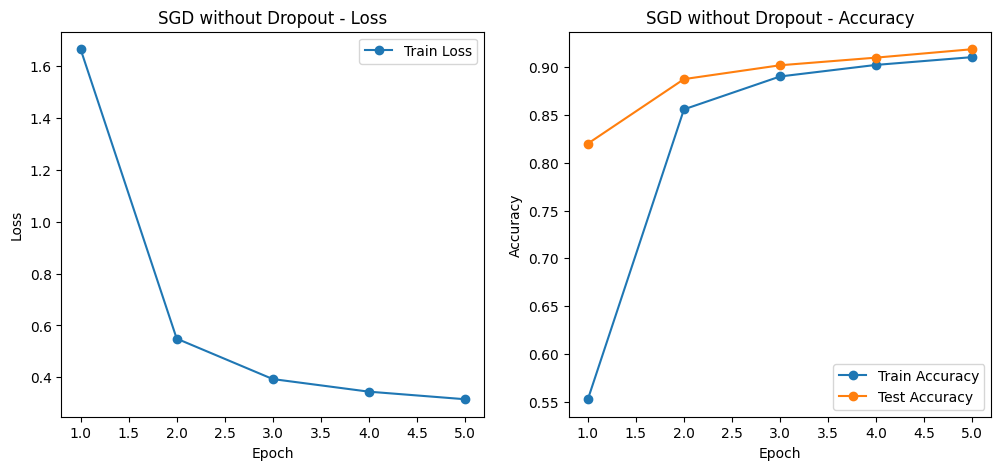


▶ Optimizer: Adam, Dropout: False

Epoch 1
Train Loss: 0.3421 | Train Accuracy: 0.9030
Test Accuracy: 0.9525

Epoch 2
Train Loss: 0.1390 | Train Accuracy: 0.9585
Test Accuracy: 0.9650

Epoch 3
Train Loss: 0.0945 | Train Accuracy: 0.9717
Test Accuracy: 0.9666

Epoch 4
Train Loss: 0.0699 | Train Accuracy: 0.9784
Test Accuracy: 0.9756

Epoch 5
Train Loss: 0.0554 | Train Accuracy: 0.9831
Test Accuracy: 0.9751


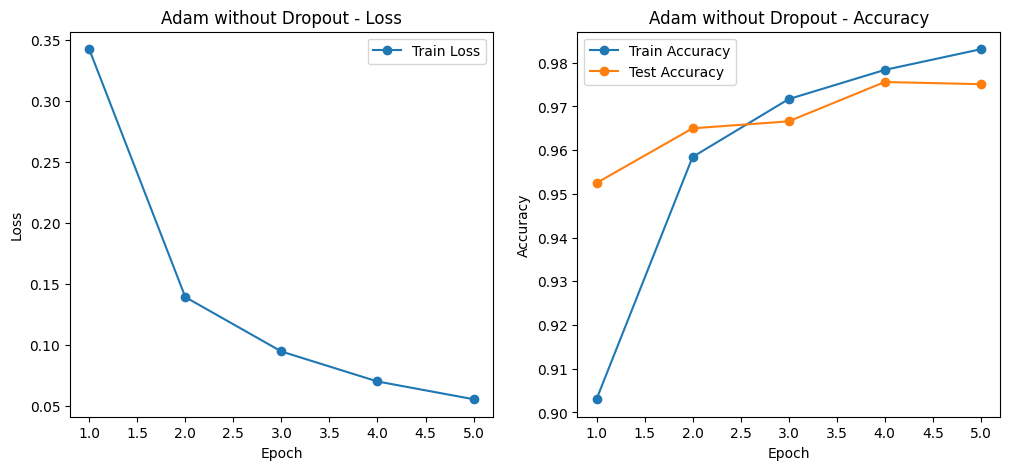


▶ Optimizer: SGD, Dropout: True

Epoch 1
Train Loss: 1.8708 | Train Accuracy: 0.4408
Test Accuracy: 0.7900

Epoch 2
Train Loss: 0.8451 | Train Accuracy: 0.7411
Test Accuracy: 0.8722

Epoch 3
Train Loss: 0.5992 | Train Accuracy: 0.8206
Test Accuracy: 0.8929

Epoch 4
Train Loss: 0.5032 | Train Accuracy: 0.8536
Test Accuracy: 0.9066

Epoch 5
Train Loss: 0.4504 | Train Accuracy: 0.8696
Test Accuracy: 0.9135


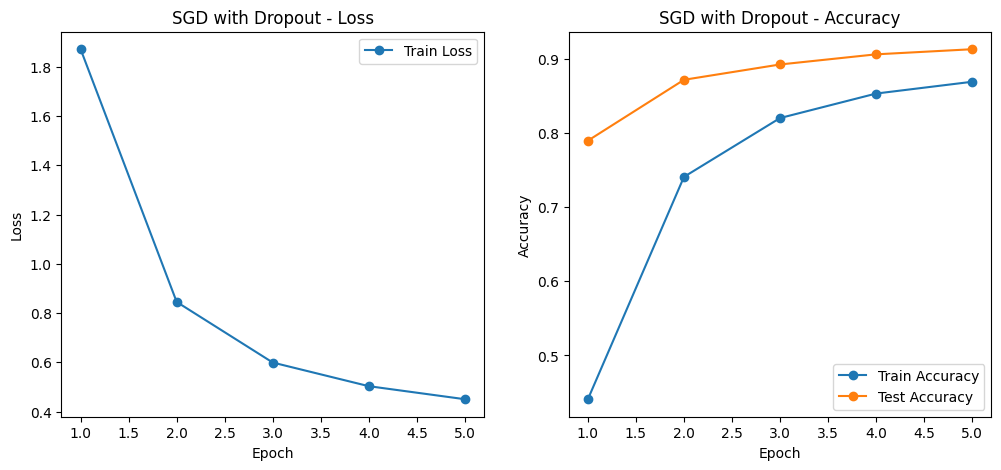


▶ Optimizer: Adam, Dropout: True

Epoch 1
Train Loss: 0.4495 | Train Accuracy: 0.8661
Test Accuracy: 0.9420

Epoch 2
Train Loss: 0.2161 | Train Accuracy: 0.9360
Test Accuracy: 0.9607

Epoch 3
Train Loss: 0.1679 | Train Accuracy: 0.9511
Test Accuracy: 0.9688

Epoch 4
Train Loss: 0.1422 | Train Accuracy: 0.9579
Test Accuracy: 0.9717

Epoch 5
Train Loss: 0.1277 | Train Accuracy: 0.9621
Test Accuracy: 0.9730


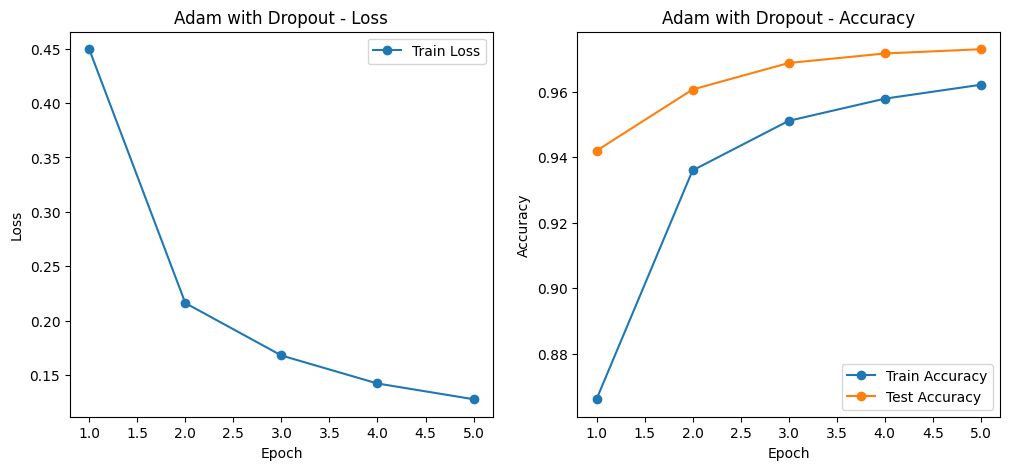

In [16]:
# [6] 실험 실행 (총 4개)

set_seed()

# 실험 1: SGD + No Dropout
run_experiment('SGD', False)

# 실험 2: Adam + No Dropout
run_experiment('Adam', False)

# 실험 3: SGD + Dropout
run_experiment('SGD', True)

# 실험 4: Adam + Dropout
run_experiment('Adam', True)

## 실험 결과 요약

| 실험 번호 | Optimizer | Dropout | Train Accuracy (%) | Test Accuracy (%) |
| ----- | --------- | ------- | ------------------ | ----------------- |
| 1     | SGD       | ❌       | 91.06              | 91.89             |
| 2     | Adam      | ❌       | 98.31              | 97.51             |
| 3     | SGD       | ✅       | 86.96              | 91.35             |
| 4     | Adam      | ✅       | 96.21              | 97.30             |


→ 최고 성능은 ‘Adam + No Dropout’ 조합
- Dropout은 특히 SGD에서 Train Accuracy를 낮추지만 Test Accuracy는 큰 차이가 없음